In [7]:
# Import relevant libraries & packages

#%pip install json-normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline


In [8]:
# Read the credits csv file 
df_credits= pd.read_csv('/Users/pree/Desktop/credits.csv')
#df_credits.head()

In [9]:
# Read the tmdb file
df_tmdb= pd.read_csv('/Users/pree/Desktop/tmdb_5000_movies.csv')
#df_tmdb.head()

In [10]:
# Merge the two tables on id column and make id the index
df = pd.merge(df_credits, df_tmdb, on= 'id')
df.head()

,cast,crew,id,budget,genres,homepage,keywords,original_language,original_title,overview,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,30000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",http://toystory.disney.com/toy-story,"[{""id"": 931, ""name"": ""jealousy""}, {""id"": 4290,...",en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-10-30,373554033,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Toy Story,7.7,5269
1,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...",710,58000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",http://www.mgm.com/view/movie/757/Goldeneye/,"[{""id"": 701, ""name"": ""cuba""}, {""id"": 769, ""nam...",en,GoldenEye,James Bond must unmask the mysterious head of ...,...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1995-11-16,352194034,130.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,No limits. No fears. No substitutes.,GoldenEye,6.6,1174
2,"[{'cast_id': 1, 'character': 'Andrew Shepherd'...","[{'credit_id': '52fe44dac3a36847f80adfa3', 'de...",9087,62000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,"[{""id"": 833, ""name"": ""white house""}, {""id"": 84...",en,The American President,"Widowed U.S. president Andrew Shepherd, one of...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-11-17,107879496,106.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Why can't the most powerful man in the world h...,The American President,6.5,195
3,"[{'cast_id': 1, 'character': 'Richard Nixon', ...","[{'credit_id': '52fe43c59251416c7501d6f3', 'de...",10858,44000000,"[{""id"": 36, ""name"": ""History""}, {""id"": 18, ""na...",NaN,"[{""id"": 840, ""name"": ""usa president""}, {""id"": ...",en,Nixon,An all-star cast powers this epic look at Amer...,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-22,13681765,192.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Triumphant in Victory, Bitter in Defeat. He Ch...",Nixon,7.1,71
4,"[{'cast_id': 1, 'character': 'Morgan Adams', '...","[{'credit_id': '52fe42f4c3a36847f802f69f', 'de...",1408,98000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,"[{""id"": 911, ""name"": ""exotic island""}, {""id"": ...",en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",...,"[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso...",1995-12-22,10017322,119.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The Course Has Been Set. There Is No Turning B...,Cutthroat Island,5.7,136


In [11]:
df.shape

(4599, 22)

# 1. Demographic filtering 
For this we need:

    1. To rate the movie
    2. calculate the score for each movie 
    3. Sort the ratings and recommend movies that are best rated to the users

    
We have two columns called 'vote_average' & 'vote_count', but as is seen for some movies we have more count than the others. Hence we need a more weighted rating than the existing one. This is becasue a movie that has a rating of 8 and 500 votes is not more popular than movie that is 6.6 with 10000 votes.

Therfeore we will use the imdb's weighted average rating, whuch gies as below:

**weighted rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶**


where:
𝑅 = average for the movie (mean) = (Rating)
𝑣 = number of votes for the movie = (votes)
𝑚 = minimum votes required to be listed in the Top 50 (currently 1000)
𝐶 = the mean vote across the whole report (currently 6.8)

We already have v(vote_count) and R (vote_average), m = 1000 and C = 6.8


In [12]:
#Lets check the shape of the dataframe after adding the qualification criterion
m = 1000
C = 6.8

qual_movies = df.copy().loc[df['vote_count'] >= m]
qual_movies.shape

(924, 22)

So we now have a total of 924 movies that qualify to be on the list of recommendation. We will now calculate the weighted average metric for each movie by defining a function called weighted_rating

In [13]:
def weighted_rating(x, m = m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    
    # Calculation based on the IMDB formula
    return (v/(v+m) * R)+(m/(v+m) * C)

In [14]:
# Define a new feature 'score' and calculate its value with `weighted_rating()
qual_movies['score'] = qual_movies.apply(weighted_rating, axis=1)

In [15]:
#Sort movies based on score calculated above
qual_movies = qual_movies.sort_values('score', ascending=False)

#Print the top 10 movies
qual_movies[['title', 'release_date', 'vote_count', 'vote_average', 'score']].head(10)

,title,release_date,vote_count,vote_average,score
89,The Shawshank Redemption,1994-09-23,8205,8.5,8.315318
210,The Godfather,1972-03-14,5893,8.4,8.167880
862,Fight Club,1999-10-15,9413,8.3,8.155949
85,Pulp Fiction,1994-10-08,8428,8.3,8.140899
2762,The Dark Knight,2008-07-16,12002,8.2,8.092324
103,Forrest Gump,1994-07-06,7927,8.2,8.043172
143,Schindler's List,1993-11-29,4329,8.3,8.018521
4059,Whiplash,2014-10-10,4254,8.3,8.014503
3236,Inception,2010-07-14,13752,8.1,8.011876
281,The Empire Strikes Back,1980-05-17,5879,8.2,7.996482


# Voila! Our very first basic recommender system is now in place

Under the **Trending Now** tab of these systems we find movies that are very popular and they can just be obtained by sorting the dataset by the popularity column.

Text(0.5, 1.0, 'Popular Movies')

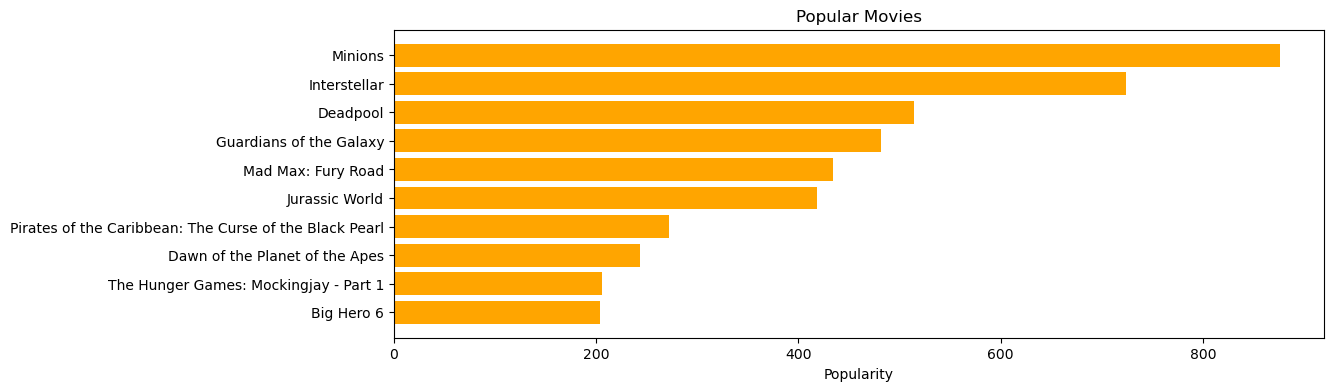

In [16]:
#Getting the popular movies from the dataframe
pop = df.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(10), pop['popularity'].head(10), align='center', color= 'orange')
plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.title('Popular Movies')

Now something to keep in mind is that these demographic recommenders provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. This is when we move on to a more refined system- **Content Based Filtering**.

# 2. Content based filtering


In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

Plot description based Recommender:
We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the overview feature of our dataset. Let's take a look at the data. ..

In [17]:
# First five rows of our 'overview' column
df['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    James Bond must unmask the mysterious head of ...
2    Widowed U.S. president Andrew Shepherd, one of...
3    An all-star cast powers this epic look at Amer...
4    Morgan Adams and her slave, William Shaw, are ...
Name: overview, dtype: object

In order to proceed further, we will need to convert the words of the documents (each movie) into vectors. We will achieve this by using the Tf-idf library. We will calculate the term frequency- inverse document frequency, whereby each movie title will form each document and then each word therein will be the word, for which we will calculate the term frequency.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give us a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.We will also drop the frequently used stop words in Enlish like the /a / is/ this/ that etc This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

To accomplish this we will use scikit-learn that gives us a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines.

In [18]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Initiate a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['overview'] = df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4599, 20322)

We see that over 20,000 different words were used to describe the 4599 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several methods for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

Cos(x, y) = x . y / ||x|| * ||y||

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [19]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [20]:
#Construct a reverse map of indices and movie titles

indices = pd.Series(df.index, index = df['title']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :

* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [21]:
# Function that takes in movie title as input and outputs most similar movies

def get_recommendations(title, cosine_sim = cosine_sim):
    # Get the index of the movie that matches the title
    index = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[index]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies, dont take [0] as its self
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [22]:
get_recommendations('Batman Forever')

3558                      The Dark Knight Rises
2193                              Batman Begins
2762                            The Dark Knight
352                              Batman Returns
393                              Batman & Robin
3786    Batman: The Dark Knight Returns, Part 2
157                                      Batman
2236                                   Cry_Wolf
2807                        The Incredible Hulk
4357         Batman v Superman: Dawn of Justice
Name: title, dtype: object

In [23]:
get_recommendations('Toy Story')

3222               Toy Story 3
906                Toy Story 2
2224    The 40 Year Old Virgin
2496    For Your Consideration
921            Man on the Moon
1611             Class of 1984
2548              Factory Girl
1576                Heartbeeps
1210                 Losin' It
2292               Match Point
Name: title, dtype: object

In [24]:
get_recommendations('Titanic')

974                                   Raise the Titanic
1579                                         Ghost Ship
3049                         I Can Do Bad All By Myself
406                                       Event Horizon
852                                             Niagara
1774                                           The Rose
3134                                           Triangle
2158                        The Ballad of Jack and Rose
2387                                           Poseidon
1813    Master and Commander: The Far Side of the World
Name: title, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "Titanic" returns all movies with water, ship, Rose and Jack. While it is more likely that the people who liked that movie are more inclined to enjoy other romantic movies. This is something that cannot be captured by the present system.

# Credits, Genres and Keywords Based Recommender

It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [25]:
#Let's see how the data looks for crew of our first movie in the list (doesnt give us much info)
df.loc[df['title'] == 'Toy Story']['crew']

0    [{'credit_id': '52fe4284c3a36847f8024f49', 'de...
Name: crew, dtype: object

In [26]:
pd.json_normalize(df.crew[0])

NotImplementedError: 

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)
    

Next, we'll write functions that will help us to extract the required information from each feature.

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


In [ ]:
pd.json_normalize(df.cast[0])

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg
5,19,Hamm (voice),52fe4284c3a36847f8024fa9,2,7907,John Ratzenberger,5,/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg
6,20,Bo Peep (voice),52fe4284c3a36847f8024fad,1,8873,Annie Potts,6,/eryXT84RL41jHSJcMy4kS3u9y6w.jpg
7,26,Andy (voice),52fe4284c3a36847f8024fc1,0,1116442,John Morris,7,/vYGyvK4LzeaUCoNSHtsuqJUY15M.jpg
8,22,Sid (voice),52fe4284c3a36847f8024fb1,2,12901,Erik von Detten,8,/twnF1ZaJ1FUNUuo6xLXwcxjayBE.jpg
9,23,Mrs. Davis (voice),52fe4284c3a36847f8024fb5,1,12133,Laurie Metcalf,9,/unMMIT60eoBM2sN2nyR7EZ2BvvD.jpg


In [ ]:
# Returns the features list' top 3 elements or entire list; whichever is greater

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) >3:
            names = names[:3]
        return names
    
    #Return empty list in case of missing/malformed data
    return []

In [ ]:
# Define new director, cast, genres and keywords features that are in a suitable form.

df['director'] = df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(get_list)

In [ ]:
# Print the new features of the first 5 films

df[['title', 'cast', 'director', 'keywords', 'genres']]

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,GoldenEye,"[Pierce Brosnan, Sean Bean, Izabella Scorupco]",Martin Campbell,"[cuba, falsely accused, secret identity]","[Adventure, Action, Thriller]"
2,The American President,"[Michael Douglas, Annette Bening, Michael J. Fox]",Rob Reiner,"[white house, usa president, new love]","[Comedy, Drama, Romance]"
3,Nixon,"[Anthony Hopkins, Joan Allen, Powers Boothe]",Oliver Stone,"[usa president, presidential election, waterga...","[History, Drama]"
4,Cutthroat Island,"[Geena Davis, Matthew Modine, Frank Langella]",Renny Harlin,"[exotic island, treasure, map]","[Action, Adventure]"
...,...,...,...,...,...
4594,Christmas Mail,"[Ashley Scott, A.J. Buckley, Rolanda Watts]",John Murlowski,[],"[Comedy, Family]"
4595,Good Intentions,"[Luke Perry, LeAnn Rimes, Jimmi Simpson]",Jim Issa,[independent film],[Comedy]
4596,Growing Up Smith,"[Roni Akurati, Brighton Sharbino, Jason Lee]",Frank Lotito,[],"[Comedy, Family, Drama]"
4597,Aroused,"[Lisa Ann, Kayden Kross, Belladonna]",Deborah Anderson,"[pornography, interview, biography]",[Documentary]


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same. 

In [ ]:
# Function to convert all strings to lower case and strip names of spaces

def clean_data(x):
        #for list columns
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else: 
        #for non-list column(director), check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else: 
            return ''
        

In [ ]:
#apply clean data function to features
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

df[features].head()

,cast,keywords,director,genres
0,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy]",johnlasseter,"[animation, comedy, family]"
1,"[piercebrosnan, seanbean, izabellascorupco]","[cuba, falselyaccused, secretidentity]",martincampbell,"[adventure, action, thriller]"
2,"[michaeldouglas, annettebening, michaelj.fox]","[whitehouse, usapresident, newlove]",robreiner,"[comedy, drama, romance]"
3,"[anthonyhopkins, joanallen, powersboothe]","[usapresident, presidentialelection, watergate...",oliverstone,"[history, drama]"
4,"[geenadavis, matthewmodine, franklangella]","[exoticisland, treasure, map]",rennyharlin,"[action, adventure]"


We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director, genres and keywords).

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + ' '.join(x['director']) + ' ' + ' '.join(x['genres'])
df['soup'] = df.apply(create_soup, axis = 1)

df['soup'].head()


0    jealousy toy boy tomhanks timallen donrickles ...
1    cuba falselyaccused secretidentity piercebrosn...
2    whitehouse usapresident newlove michaeldouglas...
3    usapresident presidentialelection watergatesca...
4    exoticisland treasure map geenadavis matthewmo...
Name: soup, dtype: object

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weigh the presence of an actor/director if he or she has acted or directed in relatively more movies.

Collaborative Filtering:

The content based engine created by us has several limitations. It can only recommend movies that are similar, in that, it is not capable of capturing user tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. 
It is basically of two types:-

1. User based filtering- These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.

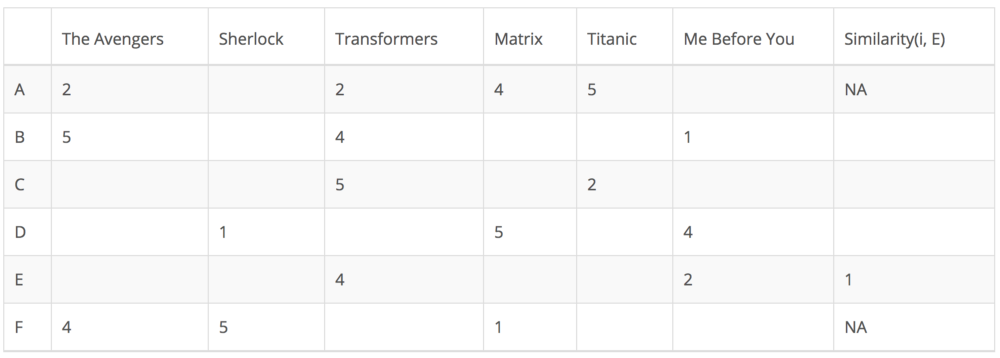

Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.

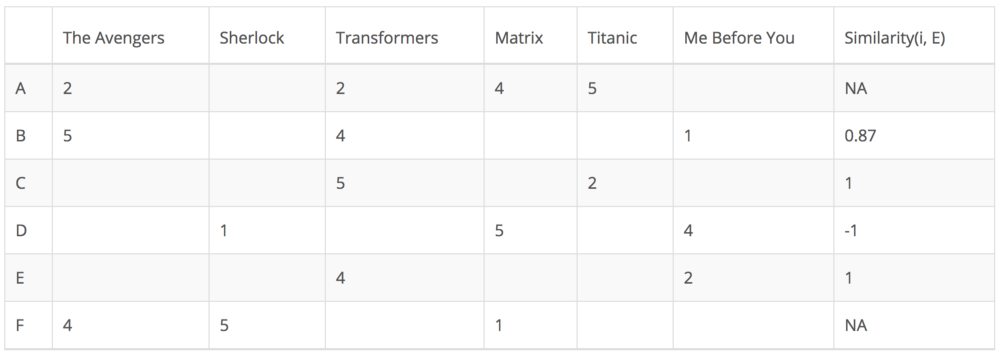

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.

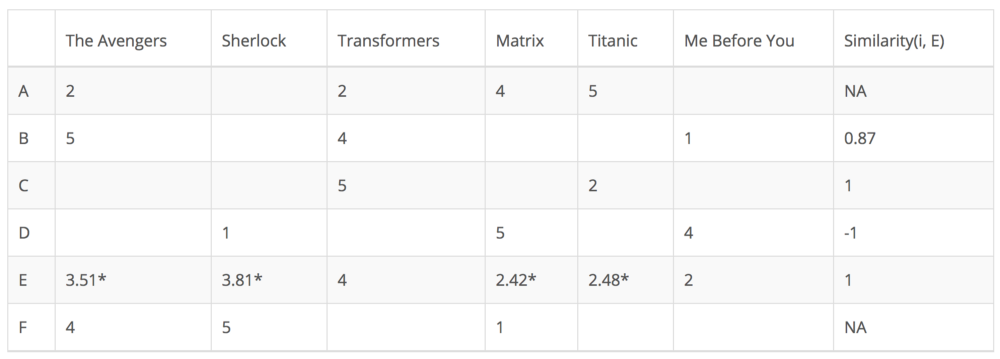

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

2. Item Based Collaborative Filtering - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.

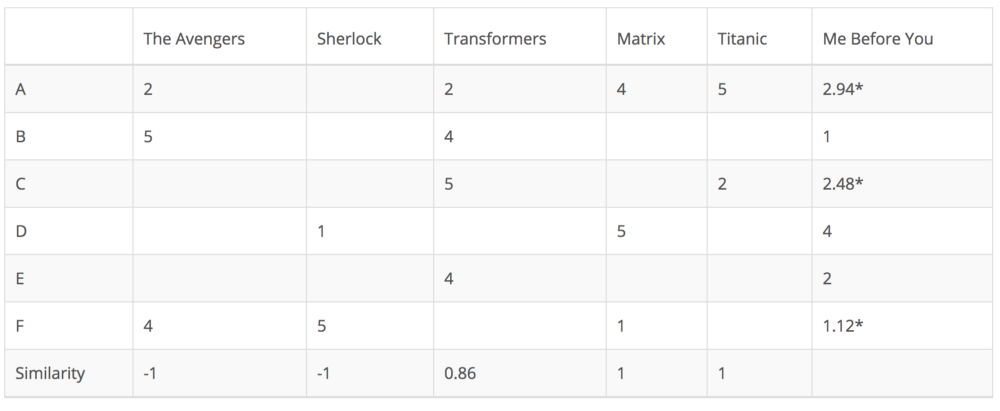

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is scalability. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, sparsity is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.

Single Value Decomposition:

One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. The below figure illustrates this idea.

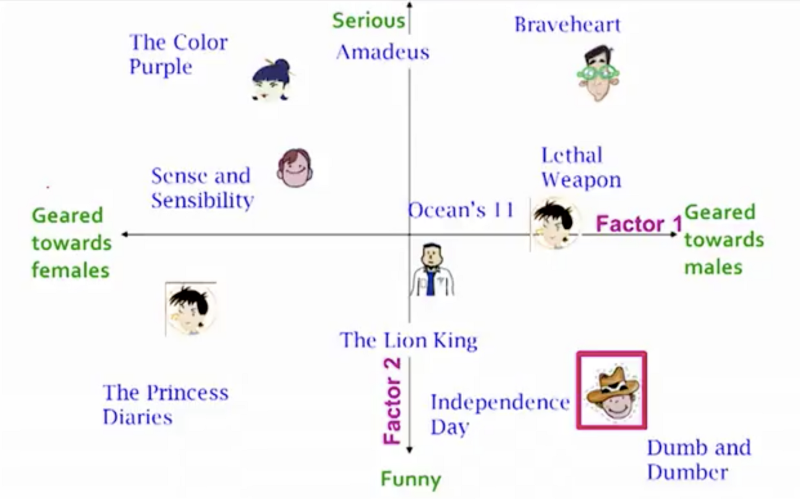

Now let's see how to implement this. Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the Surprise library to implement SVD.

In [ ]:
#!pip install scikit-surprise



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 882.0 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-macosx_10_9_x86_64.whl size=1140985 sha256=891470a9b8411e34b938dae7329a2dc010c24a12f6db6d7e4d2bf5e3a77be579
  Stored in directory: /Users/pree/Library/Caches/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split


In [27]:
# Load data (using the small ratimgs dataset from imdb)
ratings = pd.read_csv('/Users/pree/Desktop/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Note that in this dataset movies are rated on a scale of 5 unlike the earlier one.

In [29]:
# Load data
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], Reader())

In [30]:
# Train-test split
trainset, testset = train_test_split(data, test_size=.25, random_state=123)


In [31]:
# Train model
algo = SVD()
algo.fit(trainset)

In [32]:
# Predict on test set
predictions = algo.test(testset)

In [33]:
# Evaluate performance
accuracy.rmse(predictions)

RMSE: 0.8976


0.8976028475332024

We get a mean Root Mean Sqaure Error of 0.89 approx which is more than good for our case. Let us now train on our dataset and arrive at predictions.

Let us pick user with user Id 1 and check the ratings she/he has given.

In [41]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [43]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.263092097734179, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 3.263. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

Conclusion:

We create recommenders using demographic , content- based and collaborative filtering. While demographic filtering is very elemantary and cannot be used practically, hybrid systems can take advantage of content-based and collaborative filtering as the two approaches are proved to be almost complimentary. This model was very baseline and only provides a fundamental framework to start with.